In [16]:
import re
import random
import pandas as pd
import hashlib

In [17]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [18]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
"The Simulacra, Dick",113.243110,5.960164,22.138608,19
Windows PATH Variable,336.732292,11.224410,72.160509,30
Terraform,27.416399,13.708199,14.980307,2
Node.JS and React,857.754106,27.669487,102.932167,31
"Mexican Gothic, Moreno-Garcia",1139.605285,40.700189,191.633232,28
Azure Compute Gallery,291.538912,41.648416,80.413702,7
Django,1843.666670,46.091667,225.310387,40
Azure Functions Core Tools,843.085325,49.593254,142.131076,17
Node.js and Vite,2433.608909,59.356315,259.935169,41
Python,4653.872135,60.439898,302.043420,77


# Histogram

sum of ages: ~48767.34


<Axes: >

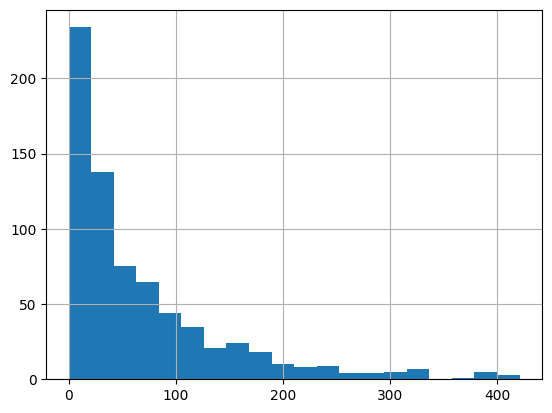

In [19]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~48767.34


<Axes: >

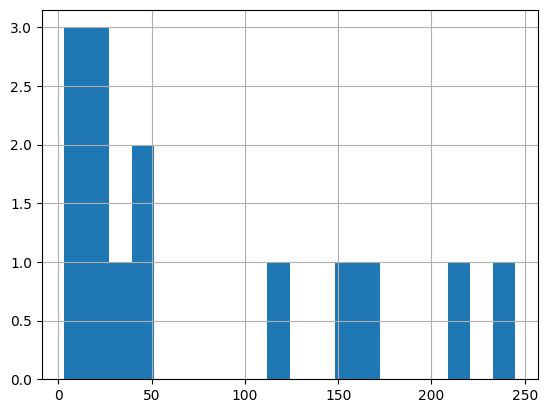

In [20]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Vocab']['age'].hist(bins=20)

# Completely Random Shuffle

In [21]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [22]:
existing_cards = existing_cards.sort_values('age', ascending=False)
remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
existing_cards.head(10)

Cards found: 710
Total card age: 48767.34


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count
0,Terraform Codebox,The terraform.tfvars file allows you to define...,53f7413f3c7191d894dab650181ee887,420.831767,102.130761,420.831767,4289.491941,0.112530,42
1,Terraform Codebox,Terraform custom_data for cloud-init\nA base64...,0fff0b324c270d9764802ea5dd18c942,407.048358,102.130761,420.831767,4289.491941,0.112530,42
2,PnP PowerShell,OAuth 2.0 Client Credentials Flow\nAn authenti...,c90c2d49a1ca2f62bae14c4a35f4e965,401.294875,112.451668,401.294875,1799.226695,0.591608,16
5,Accounting,Statement of Cash Flows\nFinancial statement r...,211b431777af17ed8e07efa02b7abf07,399.667964,82.776588,399.667964,1407.201993,0.217887,17
3,Azure Files Documentation,"The procedures for changing the size, cost, an...",6dbf200ea927231b69d01af54d5a79e0,399.255429,70.775666,399.255429,4246.539968,0.166348,60
4,TSQL,Common Table Expressions (CTEs):\n\nDefined wi...,522cef69fcbe464e6ab1658001074efa,394.906559,82.674694,394.906559,1488.144499,0.248712,18
6,"The Starless Crown, Rollins",Servitor (SUR-vi-tor)\nnoun\nAn attendant or s...,e053849c090b585983cd577f6bd34e32,393.108043,101.197704,393.108043,2732.338006,0.463075,27
7,Azure Files Documentation,# Create the Kerberos key on the storage accou...,9b97063601340ca00170a182d9ee43af,384.586285,70.775666,399.255429,4246.539968,0.166348,60
8,pfSense,"For several essential and optional services, s...",fd2e4588d6e2b8185c613b7fd76212fb,374.005148,132.723026,374.005148,1459.953284,0.105120,11
9,PnP PowerShell,Token Expiry\nThe duration an OAuth 2.0 access...,a25882e335343da6802e2a0689de2780,336.511406,112.451668,401.294875,1799.226695,0.591608,16


# N-fold shuffle


## Age Sum

In [23]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [24]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [25]:
# n = random.choice([2, 3, 3, 4, 5, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [26]:
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

# choices = ['floor', 'mod']
# option = random.choice(choices)
# if option == 'floor':
#     n=5
#     existing_cards['n_fold'] = existing_cards['count'] // n
#     print("floor dividing for n-fold")
# elif option == 'mod':
#     n=3
#     existing_cards['n_fold'] = existing_cards['count'] % n
#     print("modulo for n-fold")
# else: raise NotImplementedError


# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [27]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [28]:
existing_cards.head(10)['age'].sum()

np.float64(3911.2158350575855)

In [29]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count
0,Terraform Codebox,The terraform.tfvars file allows you to define...,53f7413f3c7191d894dab650181ee887,420.831767,102.130761,420.831767,4289.491941,0.112530,42
1,Terraform Codebox,Terraform custom_data for cloud-init\nA base64...,0fff0b324c270d9764802ea5dd18c942,407.048358,102.130761,420.831767,4289.491941,0.112530,42
2,PnP PowerShell,OAuth 2.0 Client Credentials Flow\nAn authenti...,c90c2d49a1ca2f62bae14c4a35f4e965,401.294875,112.451668,401.294875,1799.226695,0.591608,16
5,Accounting,Statement of Cash Flows\nFinancial statement r...,211b431777af17ed8e07efa02b7abf07,399.667964,82.776588,399.667964,1407.201993,0.217887,17
3,Azure Files Documentation,"The procedures for changing the size, cost, an...",6dbf200ea927231b69d01af54d5a79e0,399.255429,70.775666,399.255429,4246.539968,0.166348,60
4,TSQL,Common Table Expressions (CTEs):\n\nDefined wi...,522cef69fcbe464e6ab1658001074efa,394.906559,82.674694,394.906559,1488.144499,0.248712,18
6,"The Starless Crown, Rollins",Servitor (SUR-vi-tor)\nnoun\nAn attendant or s...,e053849c090b585983cd577f6bd34e32,393.108043,101.197704,393.108043,2732.338006,0.463075,27
7,Azure Files Documentation,# Create the Kerberos key on the storage accou...,9b97063601340ca00170a182d9ee43af,384.586285,70.775666,399.255429,4246.539968,0.166348,60
8,pfSense,"For several essential and optional services, s...",fd2e4588d6e2b8185c613b7fd76212fb,374.005148,132.723026,374.005148,1459.953284,0.105120,11
9,PnP PowerShell,Token Expiry\nThe duration an OAuth 2.0 access...,a25882e335343da6802e2a0689de2780,336.511406,112.451668,401.294875,1799.226695,0.591608,16


In [30]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 68.686'